In [1]:
import numpy as np
c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 입력 (one-hot)
W = np.random.randn(7, 3) # 가중치 (랜덤한 값), Word vector
h = np.matmul(c, W) # 은닉층 노드
print(h)

[[ 1.19554098 -0.23543086  0.3439156 ]]


In [2]:
import sys
sys.path.append('..')

from common.layers import MatMul
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-1.23123754 -0.48054396 -0.51973019]]


In [3]:
 # 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)
# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)
# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1) # average
s = out_layer.forward(h) # score
print(s)

[[-2.06259707 -0.96784074  0.61153868 -0.68539261 -0.83350964 -0.75444994
   0.5633758 ]]


In [4]:
from common.util import preprocess
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [5]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [6]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        # wiondow_size만큼 타겟 단어 좌우 context 가져오기
        for t in range(-window_size, window_size+1):
            if t != 0:
                cs.append(corpus[idx + t])
        
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [7]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [8]:
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [11]:
def convert_one_hot(corpus, vocab_size):

    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [12]:
text = 'You say goodby and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)

target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [13]:
print(target)
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


In [26]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 레이어 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1,self.out_layer]
        self.params, self.grads = [], []
        
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T


    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss


    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [27]:
# chap03/train.py
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)

# cbow 학습 데이터셋 생성
contexts, target = create_contexts_target(corpus, window_size)

# Input에 맞는 one-hot 표현 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 모델 초기화
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [28]:
trainer.fit(contexts, target, max_epoch, batch_size)

|  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 514 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 515 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 516 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 517 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 518 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 519 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 520 |  반복 1 / 2 | 시간 0[s] | 손실 0.66
| 에폭 521 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 522 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 523 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 524 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 525 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 526 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 527 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 528 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 529 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 530 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 531 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 532 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 533 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 534 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 535 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 536 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 537 |  반복 1 / 2 | 시간

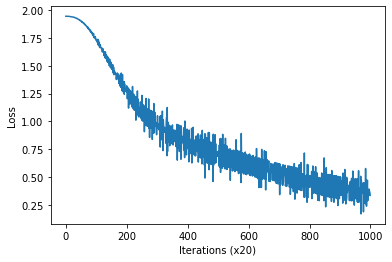

In [29]:
trainer.plot()

In [31]:
# Word Embedding 살펴보기
word_vecs1 = model.word_vecs1

for word_id, word in id_to_word.items():
    print(word, word_vecs1[word_id])

you [ 0.9810374  0.9276981 -1.0256612 -0.7274513 -1.7498773]
say [-1.1594661  -1.1794566   1.1436654   0.09712093 -1.1455401 ]
goodbye [ 1.0445026   1.0369474  -0.98637486 -1.1395257   0.3769891 ]
and [-1.0439636  -1.0600599   1.0445067  -1.9761575  -0.55348223]
i [ 1.0516133   1.0377426  -0.99020904 -1.1199282   0.3611609 ]
hello [ 0.9563576   0.9265291  -1.0225537  -0.71599466 -1.7433468 ]
. [-0.93183553 -0.9308546   0.918825    1.6551491  -1.4247652 ]


In [32]:
# Word Embedding 살펴보기
word_vecs2 = model.word_vecs2

for word_id, word in id_to_word.items():
    print(word, word_vecs2[word_id])

you [ 0.04223352 -0.09072128 -0.045676    1.2245204   1.3113146 ]
say [ 0.8493844   0.825487   -0.88995653 -0.5500546  -1.5375894 ]
goodbye [-0.6746012  -0.7196944   0.6997317  -0.8275252  -0.16325164]
and [ 0.8271799  0.8169872 -0.7825641 -0.7594461  1.5519377]
i [-0.6856733  -0.71185756  0.6875898  -0.8275841  -0.1773699 ]
hello [-0.69924927 -0.73894536  0.7054918   1.9921317  -0.49940792]
. [ 0.03890242 -0.09144811 -0.0463152   1.2132977   1.304696  ]


In [34]:
%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(word_vecs2)

In [35]:
vocab = list(id_to_word.values())

In [36]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df.shape

(7, 2)

In [37]:
df.head()

,x,y
you,-124.642464,86.139900
say,-62.692699,36.694683
goodbye,-99.592522,22.231596
and,-87.744820,100.605125
i,-56.769421,75.882431


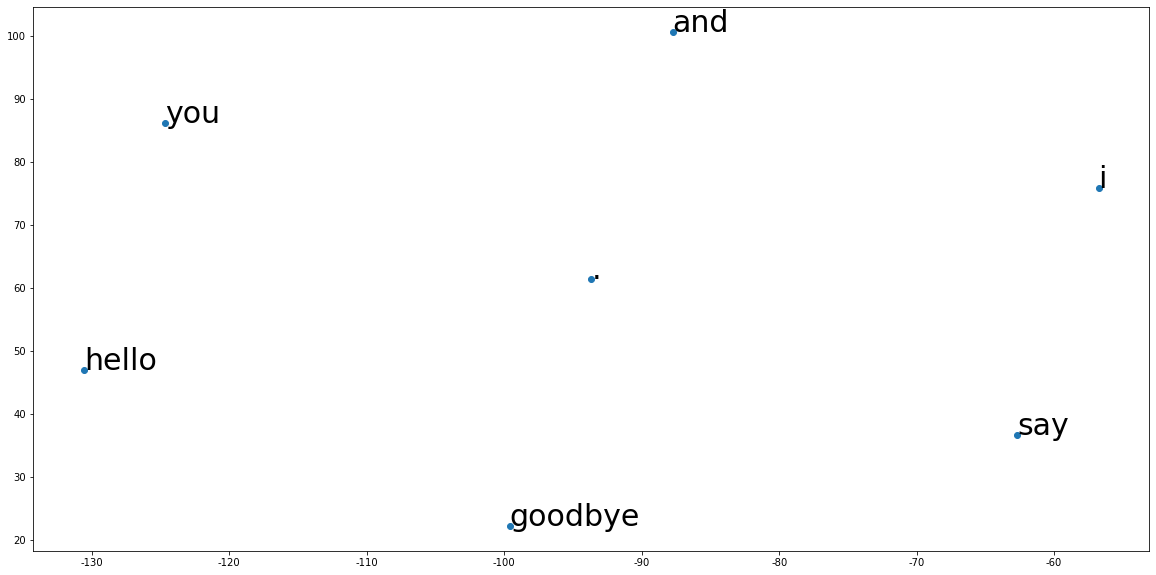

In [38]:
fig = plt.figure()
fig.set_size_inches(20, 10)

ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
    
plt.show()

In [40]:
# chap03/simple_skip_gram.py
from common.layers import MatMul, SoftmaxWithLoss

class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 레이어 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None